# **KITTI Stereo Vision - LiDAR depth**

Welcome to part 2 of the KITTI Stereo Vision Starter tutorial. In this section we will compare computed stereo depth to LiDAR point clouds, and of course we'll make some cool videos to showcase what we've learned!


Once again, the KITTI dataset is located [here]()http://www.cvlibs.net/datasets/kitti/raw_data.php a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



### **Download the Data**
Now that we have covered a bit of background let's get started! First we will download some data from the KITTI dataset and access it in the collab environment. I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified. In a future tutorial we will discuss why this is important, for now we will explore the data at a high level.

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-08-28 18:12:36--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.247
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  11.4MB/s    in 83s     

2022-08-28 18:14:00 (10.7 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



And now we will download the corresponding calibration file which contains a 3x4 projection matrix.

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-08-28 18:14:00--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.191
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-08-28 18:14:02 (235 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [3]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [4]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. The LiDAR used in the KITTI dataset is a Velodyne LiDAR, so the variables that refer to 'velo' actually refer to the LiDAR point cloud.

Just as in part1, we will use data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [5]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### **Get data**

In [6]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 227
Number of right images: 227
Number of LiDAR point clouds: 227


### **Get Camera Calibration Data**

Here we will get calibration data for both color cameras, and we will get the rotation and trnaslation matrix for LiDAR to camera frame of reference.


In [7]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

In [8]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [9]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

Once again: the projection matrices will be decomposed into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

The rectified Rotation matrices will be used to help transform a LiDAR point to the camera frame of reference.

#### **Get LiDAR to Camera Rotation and Translation Matrices**

In [10]:
with open(r'2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

T_cam_velo

array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

The LiDAR to Camer translation matrix will allow us to rotate any 3D LiDAR point to the camera pixel space

$$ y = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} x,
  \qquad \text{where } x = [x, y, z, 1]^T $$
NOTE:  x is the 3D point in homogeneous coordinates.

Since we will be using the left image we will go ahead and make a function to rotate a single LiDAR poin to the left image.

## **Define functions**
We will define all of the necessary functions to compute depth and detect object. Please refer to part 1 for more info on these functions.

In [11]:
def compute_sgbm_disparity(left_image, right_image, num_disparities=5*16, 
                           block_size=11, window_size=5, display=False):
    """ Computes the disparity of an image pair using the SGBM algoithm.
        Inputs: 
            image_left/_right - (MxN) grayscale input images
            see opencv documentation for "StereoBM_create"
        Outputs:
            disparity (MxN) computed disparity map for the input images
        
        NOTE: image_left must be the left image (same for the right) or 
              unexpected results will occur due to 
    """
    # P1 and P2 control disparity smoothness (recommended values below)
    P1 = 8 * 3 * window_size**2
    P2 = 32 * 3 * window_size**2
    sgbm_obj = cv2.StereoSGBM_create(0, num_disparities, block_size, 
        P1, P2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    # compute disparity
    disparity = sgbm_obj.compute(left_image, right_image).astype(np.float32)/16.0

    # display is desired
    if display:
      plt.figure(figsize = (40,20))
      plt.imshow(disparity, cmap='cividis')
      plt.title('Disparity Map', size=25)
      plt.show();

    return disparity

def calc_depth_map(disp_left, K_left, T_left, T_right):
    ''' Computes Depth map from Intrinsic Camera Matrix and Translations vectors.
        For KITTI, the depth is in meters.
        '''
    # Get the focal length from the K matrix
    f = K_left[0, 0]
    
    # Get the distance between the cameras from the t matrices (baseline)
    b = np.abs(T_left[0] - T_right[0])[0]
    
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left <= 0] = 1e-5
    
    # Calculate the depths 
    depth_map = f*b / disp_left 

    return depth_map

## **Get Object Detection Pipeline**

Just like part 1, we will use yolov5

In [12]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12034, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 12034 (delta 0), reused 1 (delta 0), pack-reused 12029
Receiving objects: 100% (12034/12034), 12.52 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (8276/8276), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [14]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-8-28 Python-3.7.13 torch-1.12.1+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [15]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [16]:
def get_distances(image, depth_map, bboxes, method='median', draw=True):
    ''' Obtains distance measurements for each detected object in the image 
        Inputs:
          image - input image for detection 
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each 
                  bounding box
        '''
    for bbox in bboxes:
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()
        
        # get center location on image
        x_center = np.round((pt1[1] + pt2[1]) / 2).astype(int)
        y_center = np.round((pt1[0] + pt2[0]) / 2).astype(int)

        # get depth slice
        depth_slice = depth_map[pt1[1]:pt2[1], pt1[0]:pt2[0]]

        # compute median depth to get the distance
        if method == 'center':
            x_c = np.round((pt2[1] - pt1[1]) / 2).astype(int)
            y_c = np.round((pt2[0] - pt1[0]) / 2).astype(int)
            stereo_depth = depth_slice[x_c, y_c]
        else:
            stereo_depth = np.median(depth_slice)

        # draw depth on image at center of each bounding box
        if draw:
            cv2.putText(image, 
                        '{0:.2f} m'.format(stereo_depth), 
                        (y_center, x_center),
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    
        
    return image

In [46]:
def get_depth_detections(left_image, right_image, method='median', 
                         draw_boxes=True, draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo 
        pair. The images are assumed to have already been rectified. Parameters 
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    # convert to grayscale
    left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_RGB2GRAY)
    right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_RGB2GRAY)

    ## 1. compute left disparity map
    disparity = compute_sgbm_disparity(left_image_gray, 
                                       right_image_gray, 
                                       num_disparities=96, 
                                       block_size=7, 
                                       window_size=7)

    ## 2. compute left depth map
    depth_map = calc_depth_map(disparity, K_left, T_left, T_right)

    # filter depth map
    filtered_depth_map = cv2.medianBlur(depth_map, 5)

    ## 3. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get distance measurements for image
    left_image = get_distances(left_image, 
                               filtered_depth_map, 
                               bboxes, 
                               method, 
                               draw_depth)

    return left_image, filtered_depth_map, bboxes

We now have our full pipeline from part 1. Now let's find out how to check the accuracy of our stereo depth computations!

In [24]:
index = 100

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[index]), cv2.COLOR_BGR2RGB)

left_image, depth_map, _ = get_depth_detections(left_image, right_image, method='median', 
                                                draw_boxes=True, draw_depth=True)

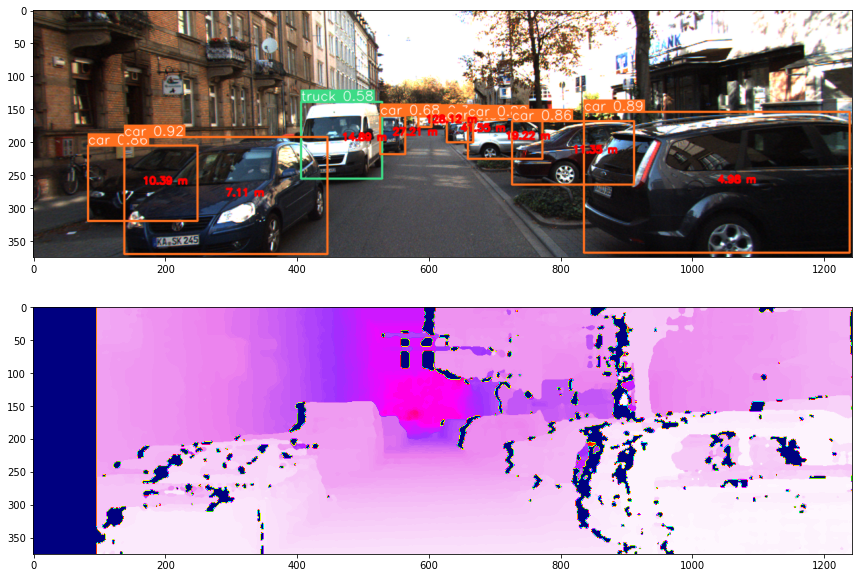

In [25]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

_, ax = plt.subplots(2, 1, figsize=(15, 10))

ax[0].imshow(left_image);
ax[1].imshow(np.log(depth_map), cmap='gist_ncar_r');

### **Create LiDAR points pipeline**

We will read in the LiDAR point clouds and transform them to the image plane. The code is partially based on the this [repository](https://github.com/azureology/kitti-velo2cam). Once again the information for the calibration parameters is located [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)

In [26]:
def get_velo2cam(lidar_bin):
    ''' Converts the LiDAR point cloud to camera (u, v, z) image coordinates, 
        where z is in meters
        '''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # convert to homogeneous coordinate system
    velo_points = scan_data[:, 0:3] # (x, y, z) --> (front, left, up)
    velo_points = np.insert(velo_points, 3, 1, axis=1).T # homogeneous LiDAR points

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1) 

    # possibly use RANSAC to remove the ground plane for better viewing?

    # convert to camera coordinates
    velo_camera = P_left @ R_left_rect @ T_cam_velo @ velo_points

    # delete negative camera points ??
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1) 

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    return velo_camera

In [27]:
def project_velo2cam(lidar_bin, image):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get camera (u, v, z) coordinates
    velo_camera = get_velo2cam(lidar_bin)

    (u, v, z) = velo_camera

    # remove outliers (points outside of the image frame)
    img_h, img_w, _ = image.shape
    u_out = np.logical_or(u < 0, u > img_w)
    v_out = np.logical_or(v < 0, v > img_h)
    outlier = np.logical_or(u_out, v_out)
    velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)
    
    return velo_camera

### **Test the LiDAR projection pipeline**

In [61]:
index = 220

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

(u, v, z) = project_velo2cam(lidar_bin, left_image)

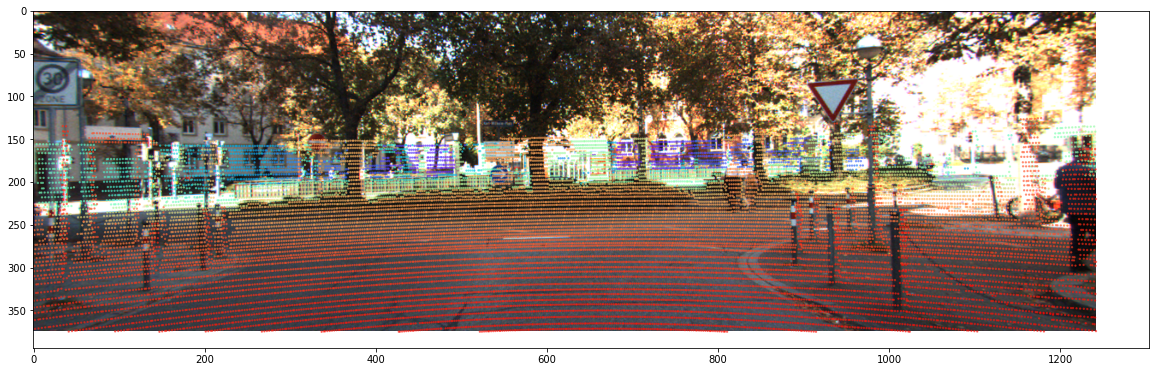

In [62]:
# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

## **Let's go ahead and turn this into a video!**

In [63]:
from matplotlib import cm

rainbow_r = cm.get_cmap('rainbow_r', lut=100)
get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

In [241]:
result_video = []

for idx in range(len(left_image_paths)):

    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    (u, v, z) = project_velo2cam(lidar_bin, left_image)

    # draw LiDAR point cloud on image
    for i in range(len(u)):
        cv2.circle(left_image, (int(u[i]), int(v[i])), 1, 
                  get_color(z[i]), -1);
    
    result_video.append(left_image)


# get width and height for video frames
h, w, _ = left_image.shape

out = cv2.VideoWriter('lidar_proj_2011_09_26.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

#### Now we need a way to determine the LiDAR measured distance at a certain image coordinate

In [42]:
def get_stereo_depth_errors(bboxes, velo_camera, method='median'):
    ''' Obtains errors for stereo depth estimation, uses velodyne LiDAR data for
        truth reference
        '''

    errors = []
    centers = []

    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    for bbox in bboxes:
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()
        
        # get center location
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                      - np.array([[x_center, y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        velo_depth = z[min_loc]

        # get correpsonding LiDAR Centers
        velo_center = np.array([v[min_loc], u[min_loc]])

        # get depth slice
        depth_slice = depth_map[pt1[1]:pt2[1], pt1[0]:pt2[0]]

        # compute median depth to get the distance
        if method == 'center':
            x_c = np.round((pt2[1] - pt1[1]) / 2).astype(int)
            y_c = np.round((pt2[0] - pt1[0]) / 2).astype(int)
            stereo_depth = depth_slice[x_c, y_c]
        else:
            stereo_depth = np.median(depth_slice)

        # compute depth error
        depth_error = stereo_depth - velo_depth

        # add to output array
        errors.append([stereo_depth, velo_depth, depth_error])
        centers.append([np.array([x_center, y_center]), velo_center])

    return np.array(errors), np.array(centers)

In [43]:
index = 220
left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)

velo_camera = project_velo2cam(lidar_bin, left_image)
detections = model(left_image)
bboxes = detections.xyxy[0]

errors, centers = get_stereo_depth_errors(bboxes, velo_camera, method='median')

## **Now make a full pipeline**
This pipeline will input a stereo pair along with a LiDAR point cloud. It will compute stereo depth and log error info

In [47]:
def stereo_depth_pipeline(left_image, right_image, lidar_bin, 
                          draw_boxes=True, method='median'):
    ''' Full pipeline to compute stereo depth errors relative to velodyne LiDAR 
        point cloud data.
        ''' 

    # get depth detections
    left_image, depth_map, bboxes = get_depth_detections(left_image, 
                                                         right_image, 
                                                         method='median',
                                                         draw_boxes=draw_boxes)

    # transform and project LiDAR points to camera points
    velo_camera = project_velo2cam(lidar_bin, left_image)

    # get stereo depth errors
    errors, centers = get_stereo_depth_errors(bboxes, 
                                              velo_camera, 
                                              method='median')
    
    return left_image, velo_camera, errors, centers

In [48]:
index = 220

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread(right_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]


left_image, velo_camera, errors, centers = stereo_depth_pipeline(
                                                            left_image, 
                                                            right_image, 
                                                            lidar_bin, 
                                                            draw_boxes=True, 
                                                            method='median')

In [49]:
errors

array([[     4.8349,      8.0286,     -3.1938],
       [     11.041,      18.394,     -7.3526],
       [ 3.8437e+07,       7.966,  3.8437e+07]])

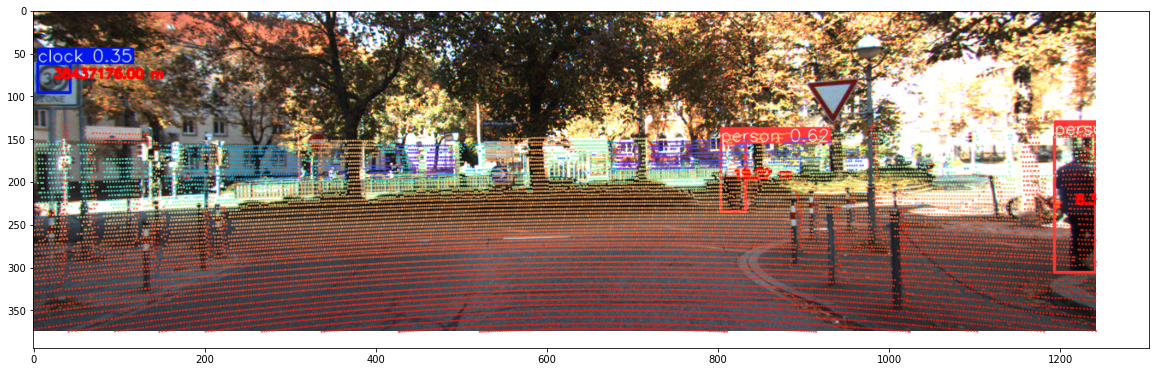

In [50]:
u, v, z = velo_camera

plt.imshow(left_image)
plt.scatter(u, v, c=z, cmap='rainbow_r', alpha=0.5, s=2);

In this case aside from the clock which is horribly wrong due to it being outside the disparity map. The predicted stereo depth is closer than the true LiDAR depth.

## **Now let's make some output videos**

While we make these output videos we will also gather error data!

In [52]:
error_metrics = []
# result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    left_image, velo_camera, errors, centers = stereo_depth_pipeline(
                                                                left_image, 
                                                                right_image, 
                                                                lidar_bin, 
                                                                draw_boxes=True, 
                                                                method='median')
    
    # result_video.append(left_image)

    # ensure that errors were recorded
    if len(errors) > 0:
        error_metrics.append(errors)

# get width and height for video frames
# h, w, _ = left_image.shape

# out = cv2.VideoWriter('boxed_video_2011_09_26.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
 
# for i in range(len(result_video)):
#     out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
# out.release()

In [56]:
error_metrics = np.vstack(error_metrics)

velo_depth =  error_metrics[:, 1]
abs_depth_error = np.abs(error_metrics[:, 2])

# remove outliers
velo_depth = velo_depth[abs_depth_error < 100]
abs_depth_error = abs_depth_error[abs_depth_error < 100]

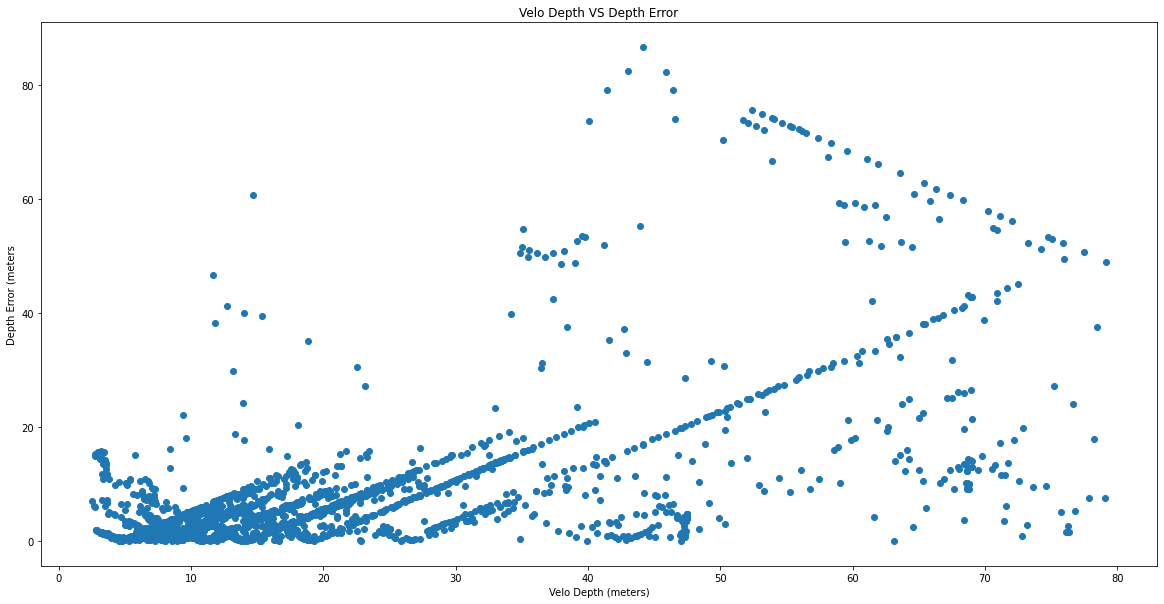

In [57]:
plt.scatter(velo_depth, abs_depth_error)
plt.title('Velo Depth VS Depth Error');
plt.xlabel('Velo Depth (meters)');
plt.ylabel('Depth Error (meters');

We can see from the depth error plot that most detections over 40 meters have a relatively higher stereo depth error than detection of less than 40 meters. 

## **Now let's run the depth check on another sample of KITTI data!**

In [76]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-08-28 18:56:13--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.92
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.168.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  10.8MB/s    in 4m 36s  

2022-08-28 19:00:50 (10.7 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [77]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-08-28 19:00:51--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.151
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-08-28 19:00:52 (58.0 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [78]:
!jar xf 2011_10_03_drive_0047_sync.zip

In [79]:
!jar xf 2011_10_03_calib.zip

### Get the Calibration data

In [80]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

# decompose projection matrices
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

In [81]:
with open(r'2011_10_03/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

In [82]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837


## **Now let's make a video**

In [105]:
error_metrics = []
result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    left_image, velo_camera, errors, centers = stereo_depth_pipeline(
                                                                left_image, 
                                                                right_image, 
                                                                lidar_bin, 
                                                                draw_boxes=True, 
                                                                method='median')
    
    # draw LiDAR point cloud on new blank image
    u, v, z = velo_camera
    new_image = np.zeros_like(left_image, dtype=np.uint8)
    for i in range(len(u)):
        cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
                  get_color(z[i]), -1);
    
    # stack frames
    stacked = np.vstack((left_image, new_image))

    # add to result video
    result_video.append(stacked)

    # ensure that errors were recorded
    if len(errors) > 0:
        error_metrics.append(errors)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

# or use mp4
# out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

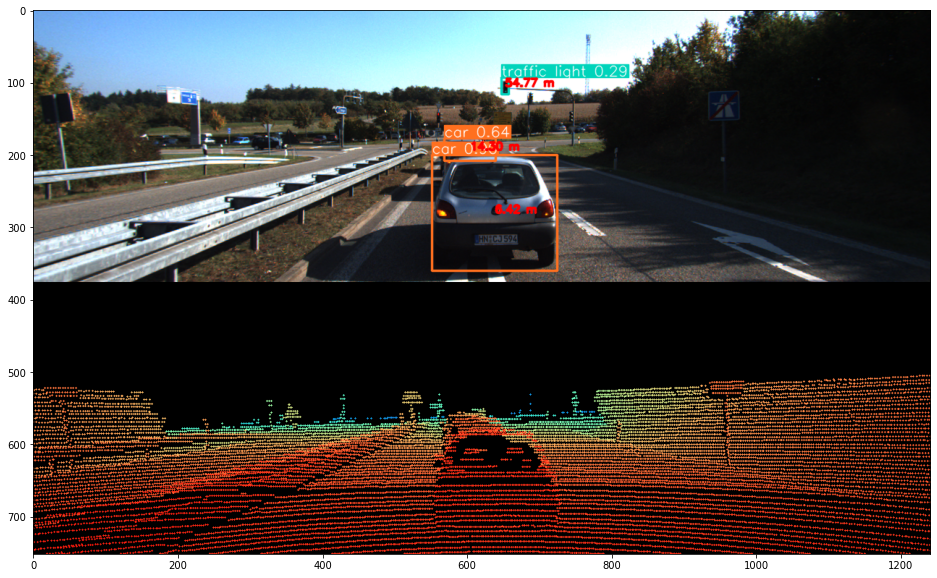

In [106]:
plt.imshow(stacked);